In [84]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [85]:
RAVD = "/Users/malakmaher/Documents/GitHub/Emotion-Recognition/dataset/archive/audio_speech_actors_01-24"

In [86]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    actor_dir = os.path.join(RAVD, i)
    fname = os.listdir(actor_dir)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(os.path.join(actor_dir, f))

        
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_surprise       96
male_angry          96
male_fear           96
male_disgust        96
male_sad            96
male_happy          96
female_fear         96
female_angry        96
female_sad          96
female_disgust      96
female_surprise     96
female_happy        96
Name: count, dtype: int64

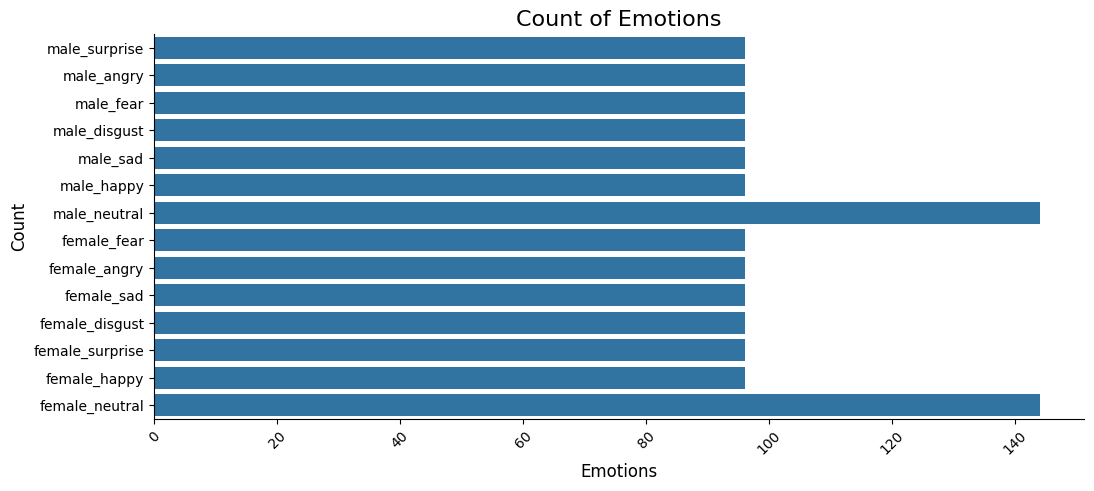

In [87]:

plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [88]:
# Female Happy
fRA1 = os.path.join(RAVD, 'Actor_08/03-01-03-02-02-01-08.wav')
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1)

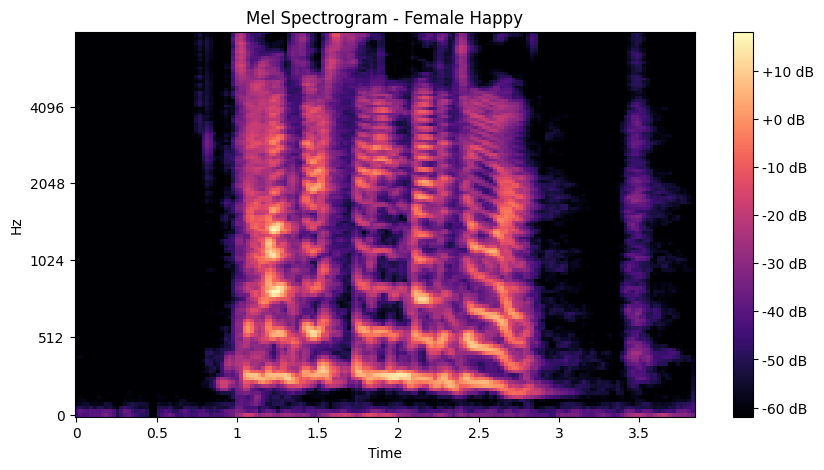

In [89]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+2.0f dB')

In [90]:
# Female Happy
fRA2 = os.path.join(RAVD, 'Actor_08/03-01-06-01-01-01-08.wav')
data, sr = librosa.load(fRA2)
ipd.Audio(fRA2)

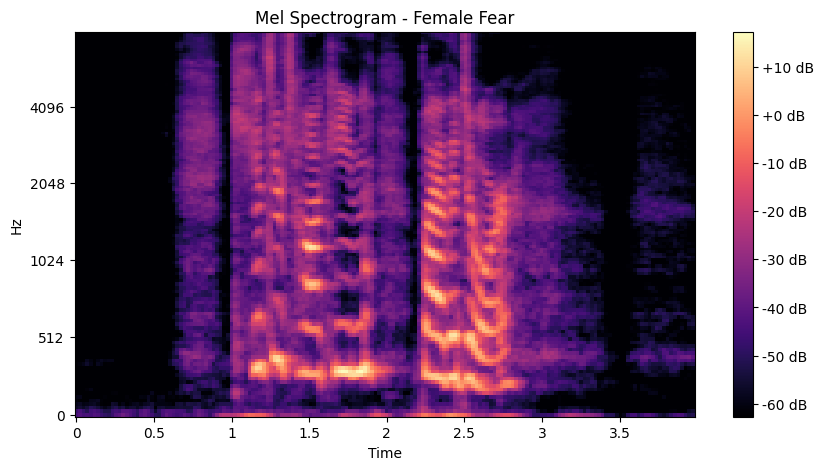

In [91]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fear')
plt.colorbar(format='%+2.0f dB');

In [92]:
# Female Disgust
fRA1 =os.path.join(RAVD, 'Actor_20/03-01-08-02-02-02-20.wav')
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 

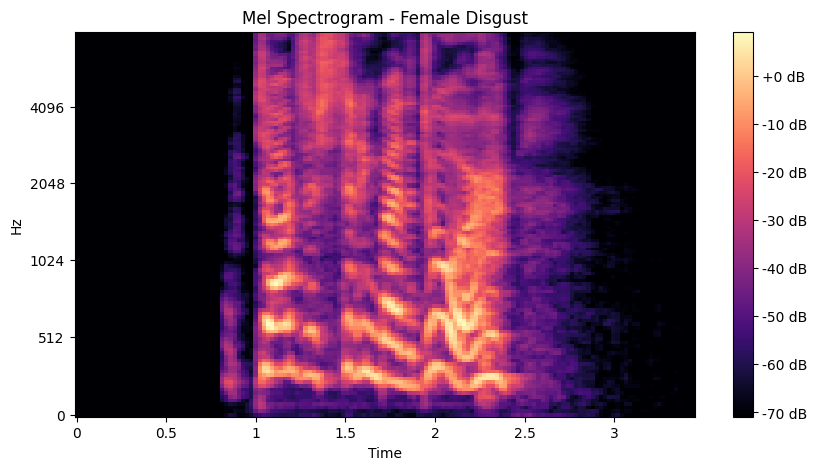

In [93]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Disgust')
plt.colorbar(format='%+2.0f dB');

In [94]:
# Male Fearfull
fRA1 = os.path.join(RAVD , 'Actor_19/03-01-04-01-02-01-19.wav')
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 

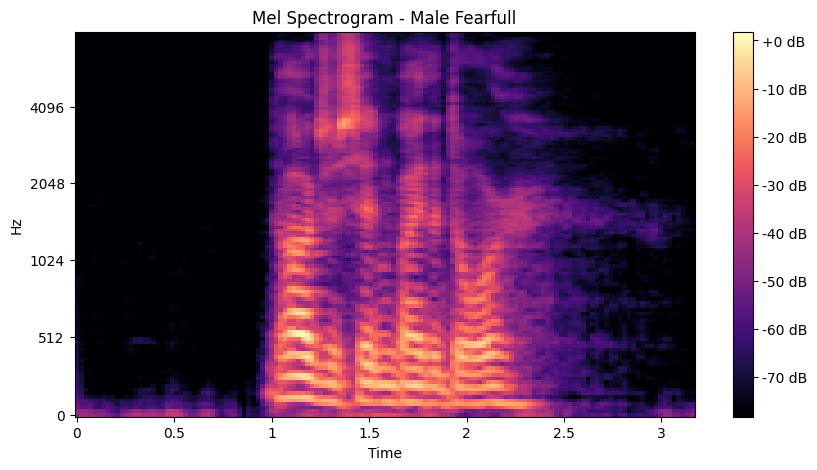

In [95]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Fearfull')
plt.colorbar(format='%+2.0f dB');

In [96]:
%pip install resampy

# Gender - Female; Emotion - Angry 
path = os.path.join(RAVD, 'Actor_18', '03-01-05-01-01-01-18.wav')
X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'resampy'

This error is lazily reported, having originally occured in
  File /opt/anaconda3/envs/emotion-env/lib/python3.10/site-packages/librosa/core/audio.py, line 32, in <module>

----> resampy = lazy.load("resampy")